In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [19]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import numpy as np
import barstrength2 as strng
import time_conversion as tiempo

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
vector2 = ('M31','MW','M33')
vector = ('00','01','03')

#path = 'home/ornela/SimCLUES/'
path = '/home/omarioni/'

atime = np.loadtxt(path + 'redshift_outputs.txt')
nsnap = atime[:,0]
nsnap = nsnap[::-1]
aexp  = atime[:,2]
aexp  = aexp[::-1]

tt = 236

path = '/mnt/is2/alejandro/ornella/'

snap = h5py.File(path + 'outputs_1/snap_'+str('%s' %int(nsnap[tt]))+'.h5py', 'r')

for i in range(0,1):
    cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
    r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value

    pstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Coordinates'].value
    mstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
    vel  = snap['subhalo_0'+ str('%s' %vector[i])+ '/Str/Velocities'].value

    z = a0/aexp[tt] - 1.
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time = tiempo.conv(z, h, omega_lambda, omega_matter)
    
    print tt, int(nsnap[tt]), time

#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0])*aexp[tt]/h
    ystr = (pstr[:,1]-cm[1])*aexp[tt]/h
    zstr = (pstr[:,2]-cm[2])*aexp[tt]/h
    r = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vel[:,0] *np.sqrt(aexp[tt]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[tt]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[tt]) + Ht *zstr/1000.

#----------------------masas----------------------------
    mstr = mstr/h

    r200 = r200*aexp[0]/h
    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    Mc_str = cumsum((mstr[limit])[r_indice])
    M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]
    r50 = r_sort[cincuenta][-1]             

#--------------------------------------------         
    veloc,=np.where(r<r50)

#----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[tt])

##posiciones de partículas que se quiere graficar
##como lo de arriba me da los versores hago las posiciones con esto 

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
#     corte, = np.where(r < 3*aexp[0])

#     A2max, rmax, phimax = strng.a2max(mstr[corte], xn[corte], yn[corte], 20)

#     xx = xn*cos(phimax)+yn*sin(phimax)
#     yy = xn*-sin(phimax)+yn*cos(phimax)
#     zz = zn

    pos=np.ndarray([4,np.size(xn)])
    pos[0,:]=xn
    pos[1,:]=yn
    pos[2,:]=zn
    pos[3,:]=mstr
    
#     pos=np.ndarray([4,np.size(xx)])
#     pos[0,:]=xx
#     pos[1,:]=yy
#     pos[2,:]=zz
#     pos[3,:]=mstr


236 260 7.49211083173


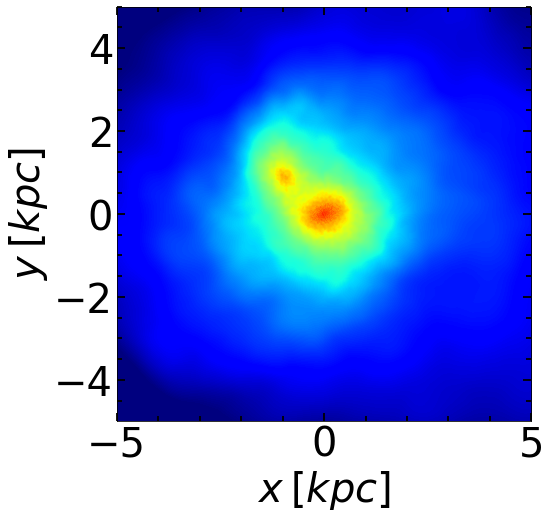

In [20]:
#-----grafico-----------
import sphviewer as sph
from __future__ import unicode_literals

#---------------------generador del gráfico-----------------
rl=6   
corte,=np.where((xn <rl) & (yn <rl) & (zn <rl) & (xn >-rl) & (yn >-rl) & (zn >-rl))


#-----rango que tiene la escala  de colores-----
vmin=3
vmax=7

# ----escala de colores que te guste (http://matplotlib.org/examples/color/colormaps_reference.html)---
cmap='jet'

nb1 = 50

particles=sph.Particles(pos[:,corte],mstr[corte]*1e10,nb=50)
escena=sph.Scene(particles)
escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl])
rend=sph.Render(escena)
extent=escena.get_extent()
rend.set_logscale()
    
fig=plt.figure(1,figsize=(8,8))
fig.subplots_adjust(bottom=0.08, left =0.2, right = 0.92, top = 0.95, wspace=0., hspace= -0.3)

ax=fig.add_subplot(111)
ax.imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
# ax.set_xticks([-4,-2,0,2,4])
# ax.set_yticks([-2,0,2])
# ax.set_xticklabels([])
ax.set_ylabel('$y\:[kpc]$', fontsize=40)
ax.set_xlabel('$x\:[kpc]$', fontsize=40)
ax.minorticks_on()
ax.tick_params( labelsize=40)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')